In [1]:
from pyspark.sql import SparkSession

# Crear una sesión de Spark
spark = SparkSession.builder \
    .appName("EDA") \
    .getOrCreate()

# Ruta del HDFS
hdfs_base_path = "hdfs://localhost:9000/datasets/"

# Cargar cada archivo Parquet en un DataFrame específico
green_jan = spark.read.parquet(hdfs_base_path + "green_tripdata_2023-01.parquet")
green_apr = spark.read.parquet(hdfs_base_path + "green_tripdata_2023-04.parquet")
green_jul = spark.read.parquet(hdfs_base_path + "green_tripdata_2023-07.parquet")
green_oct = spark.read.parquet(hdfs_base_path + "green_tripdata_2023-10.parquet")

yellow_jan = spark.read.parquet(hdfs_base_path + "yellow_tripdata_2023-01.parquet")
yellow_apr = spark.read.parquet(hdfs_base_path + "yellow_tripdata_2023-04.parquet")
yellow_jul = spark.read.parquet(hdfs_base_path + "yellow_tripdata_2023-07.parquet")
yellow_oct = spark.read.parquet(hdfs_base_path + "yellow_tripdata_2023-10.parquet")

# Detener la sesión de Spark
# spark.stop()

24/11/01 18:43:08 WARN Utils: Your hostname, bigdata resolves to a loopback address: 127.0.1.1; using 192.168.1.18 instead (on interface enp0s3)
24/11/01 18:43:08 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/01 18:43:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# Mostrar el esquema de cada DataFrame
print("Esquema de green_jan:")
green_jan.printSchema()

print("Esquema de green_apr:")
green_apr.printSchema()

print("Esquema de green_jul:")
green_jul.printSchema()

print("Esquema de green_oct:")
green_oct.printSchema()

print("Esquema de yellow_jan:")
yellow_jan.printSchema()

print("Esquema de yellow_apr:")
yellow_apr.printSchema()

print("Esquema de yellow_jul:")
yellow_jul.printSchema()

print("Esquema de yellow_oct:")
yellow_oct.printSchema()

Esquema de green_jan:
root
 |-- VendorID: long (nullable = true)
 |-- lpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- lpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- ehail_fee: integer (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- payment_type: double (nullable = true)
 |-- trip_type: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)

Esquema de green_apr:
root
 |-- VendorID: integer (nullable = true

# Operaciones de limpieza y transformación de los datos

In [3]:
from pyspark.sql.functions import lit
from pyspark.sql.types import LongType, DoubleType, TimestampType


# Paso 1: Conversión de Tipos de Datos y Normalización de Columnas
# Definir una función para convertir tipos y renombrar columnas

def standardize_columns(df, taxi_type):
    # Convertir tipos de datos
    columns_long = ["VendorID", "PULocationID", "DOLocationID", "RatecodeID", "passenger_count", "payment_type", "trip_type"]
    columns_double = ["trip_distance", "fare_amount", "extra", "mta_tax", "tip_amount", "tolls_amount", "improvement_surcharge", "total_amount", "congestion_surcharge", "Airport_fee", "ehail_fee"]
    
    for col in columns_long:
        if col in df.columns:
            df = df.withColumn(col, df[col].cast(LongType()))
    
    for col in columns_double:
        if col in df.columns:
            df = df.withColumn(col, df[col].cast(DoubleType()))
    
    # Unificación de columnas de tiempo
    if 'tpep_pickup_datetime' in df.columns:
        df = df.withColumnRenamed('tpep_pickup_datetime', 'pickup_datetime')
    elif 'lpep_pickup_datetime' in df.columns:
        df = df.withColumnRenamed('lpep_pickup_datetime', 'pickup_datetime')
    
    if 'tpep_dropoff_datetime' in df.columns:
        df = df.withColumnRenamed('tpep_dropoff_datetime', 'dropoff_datetime')
    elif 'lpep_dropoff_datetime' in df.columns:
        df = df.withColumnRenamed('lpep_dropoff_datetime', 'dropoff_datetime')
    
    # Convertir a timestamp
    df = df.withColumn("pickup_datetime", df["pickup_datetime"].cast(TimestampType()))
    df = df.withColumn("dropoff_datetime", df["dropoff_datetime"].cast(TimestampType()))
    
    # Inclusión de columnas faltantes
    if "Airport_fee" not in df.columns:
        df = df.withColumn("Airport_fee", lit(None).cast(DoubleType()))
    
    if "ehail_fee" not in df.columns:
        df = df.withColumn("ehail_fee", lit(None).cast(DoubleType()))
    
    # Agregar columna identificadora de tipo de taxi
    df = df.withColumn("taxi_type", lit(taxi_type))
    
    return df

# Estandarizar columnas y añadir columna de tipo para cada DataFrame
green_jan = standardize_columns(green_jan, "green")
green_apr = standardize_columns(green_apr, "green")
green_jul = standardize_columns(green_jul, "green")
green_oct = standardize_columns(green_oct, "green")

yellow_jan = standardize_columns(yellow_jan, "yellow")
yellow_apr = standardize_columns(yellow_apr, "yellow")
yellow_jul = standardize_columns(yellow_jul, "yellow")
yellow_oct = standardize_columns(yellow_oct, "yellow")

# Paso 2: Unión de DataFrames en un solo DataFrame para el año 2023
df_taxis = green_jan.unionByName(green_apr, allowMissingColumns=True) \
    .unionByName(green_jul, allowMissingColumns=True) \
    .unionByName(green_oct, allowMissingColumns=True) \
    .unionByName(yellow_jan, allowMissingColumns=True) \
    .unionByName(yellow_apr, allowMissingColumns=True) \
    .unionByName(yellow_jul, allowMissingColumns=True) \
    .unionByName(yellow_oct, allowMissingColumns=True)

# Mostrar el esquema y una muestra de datos para confirmar la correcta consolidación
df_taxis.printSchema()
df_taxis.show(5)

# Detener la sesión de Spark
# spark.stop()


root
 |-- VendorID: long (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- ehail_fee: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- trip_type: long (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)
 |-- taxi_type: string (nullable = false)

+--------+-------------------+

In [4]:
from pyspark.sql.functions import col, sum

# Contar valores nulos por cada columna
null_counts = df_taxis.select([sum(col(column).isNull().cast("int")).alias(column) for column in df_taxis.columns])

# Mostrar los resultados
null_counts.show()

+--------+---------------+----------------+------------------+----------+------------+------------+---------------+-------------+-----------+-----+-------+----------+------------+---------+---------------------+------------+------------+---------+--------------------+-----------+---------+
|VendorID|pickup_datetime|dropoff_datetime|store_and_fwd_flag|RatecodeID|PULocationID|DOLocationID|passenger_count|trip_distance|fare_amount|extra|mta_tax|tip_amount|tolls_amount|ehail_fee|improvement_surcharge|total_amount|payment_type|trip_type|congestion_surcharge|Airport_fee|taxi_type|
+--------+---------------+----------------+------------------+----------+------------+------------+---------------+-------------+-----------+-----+-------+----------+------------+---------+---------------------+------------+------------+---------+--------------------+-----------+---------+
|       0|              0|               0|            420663|    420663|           0|           0|         420663|            

| Columna                  | Valores Nulos      |
|--------------------------|--------------------|
| VendorID                 | 0                  |
| pickup_datetime          | 0                  |
| dropoff_datetime         | 0                  |
| store_and_fwd_flag      | 420,663            |
| RatecodeID              | 420,663            |
| PULocationID            | 0                  |
| DOLocationID            | 0                  |
| passenger_count          | 420,663            |
| trip_distance            | 0                  |
| fare_amount              | 0                  |
| extra                    | 0                  |
| mta_tax                  | 0                  |
| tip_amount               | 0                  |
| tolls_amount             | 0                  |
| ehail_fee                | 13,045,532         |
| improvement_surcharge     | 0                  |
| total_amount             | 0                  |
| payment_type             | 18,215             |
| trip_type                | 12,802,642         |
| congestion_surcharge      | 420,663            |
| Airport_fee              | 3,658,594          |
| taxi_type                | 0                  |

In [5]:
from pyspark.sql import functions as F

# 1. Eliminar registros donde la columna 'store_and_fwd_flag' y 'RatecodeID' son nulos
df_taxis = df_taxis.na.drop(subset=['store_and_fwd_flag', 'RatecodeID'])

# 2. Imputar 'tip_amount' con cero (donde no se dejó propina)
df_taxis = df_taxis.fillna({'tip_amount': 0})

# 3. Imputar 'passenger_count' con la media 
mean_passenger_count = df_taxis.select(F.mean('passenger_count')).first()[0]
df_taxis = df_taxis.fillna({'passenger_count': mean_passenger_count})

# 4. Imputar 'ehail_fee' con cero (asumiendo que es cero si no se usó el servicio)
df_taxis = df_taxis.fillna({'ehail_fee': 0})

# 5. Imputar 'payment_type' con un valor por defecto
df_taxis = df_taxis.fillna({'payment_type': 'Desconocido'})

# 6. Crear un indicador de nulos para 'tip_amount'
df_taxis = df_taxis.withColumn("tip_amount_is_null", F.when(df_taxis["tip_amount"].isNull(), 1).otherwise(0))

# 7. Imputar 'Airport_fee' con la media
mean_airport_fee = df_taxis.select(F.mean('Airport_fee')).first()[0]
df_taxis = df_taxis.fillna({'Airport_fee': mean_airport_fee})

# 8. Imputar 'congestion_surcharge' con cero (si no se aplicó)
df_taxis = df_taxis.fillna({'congestion_surcharge': 0})

# 9. Verificación de los cambios
df_taxis.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df_taxis.columns]).show()


+--------+---------------+----------------+------------------+----------+------------+------------+---------------+-------------+-----------+-----+-------+----------+------------+---------+---------------------+------------+------------+---------+--------------------+-----------+---------+------------------+
|VendorID|pickup_datetime|dropoff_datetime|store_and_fwd_flag|RatecodeID|PULocationID|DOLocationID|passenger_count|trip_distance|fare_amount|extra|mta_tax|tip_amount|tolls_amount|ehail_fee|improvement_surcharge|total_amount|payment_type|trip_type|congestion_surcharge|Airport_fee|taxi_type|tip_amount_is_null|
+--------+---------------+----------------+------------------+----------+------------+------------+---------------+-------------+-----------+-----+-------+----------+------------+---------+---------------------+------------+------------+---------+--------------------+-----------+---------+------------------+
|       0|              0|               0|                 0|        

In [6]:
df_taxis.describe().show()

24/11/01 18:43:35 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+-----------------+------------------+-------------------+------------------+------------------+---------+---------------------+------------------+------------------+-------------------+--------------------+-------------------+---------+------------------+
|summary|           VendorID|store_and_fwd_flag|        RatecodeID|     PULocationID|     DOLocationID|   passenger_count|     trip_distance|      fare_amount|             extra|            mta_tax|        tip_amount|      tolls_amount|ehail_fee|improvement_surcharge|      total_amount|      payment_type|          trip_type|congestion_surcharge|        Airport_fee|taxi_type|tip_amount_is_null|
+-------+-------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+-----------------+------------------+-------------------+--------

In [7]:
from pyspark.sql.functions import col, sum

# Contar valores nulos por cada columna
null_counts = df_taxis.select([sum(col(column).isNull().cast("int")).alias(column) for column in df_taxis.columns])

# Mostrar los resultados
null_counts.show()

+--------+---------------+----------------+------------------+----------+------------+------------+---------------+-------------+-----------+-----+-------+----------+------------+---------+---------------------+------------+------------+---------+--------------------+-----------+---------+------------------+
|VendorID|pickup_datetime|dropoff_datetime|store_and_fwd_flag|RatecodeID|PULocationID|DOLocationID|passenger_count|trip_distance|fare_amount|extra|mta_tax|tip_amount|tolls_amount|ehail_fee|improvement_surcharge|total_amount|payment_type|trip_type|congestion_surcharge|Airport_fee|taxi_type|tip_amount_is_null|
+--------+---------------+----------------+------------------+----------+------------+------------+---------------+-------------+-----------+-----+-------+----------+------------+---------+---------------------+------------+------------+---------+--------------------+-----------+---------+------------------+
|       0|              0|               0|                 0|        

In [8]:
from pyspark.sql.functions import col, when, lit

# Imputar 'tip_amount' con 0 donde sea nulo
df_taxis = df_taxis.withColumn("tip_amount", when(col("tip_amount").isNull(), lit(0)).otherwise(col("tip_amount")))

# Imputar 'passenger_count' con la mediana
median_passenger_count = df_taxis.approxQuantile("passenger_count", [0.5], 0.01)[0]
df_taxis = df_taxis.withColumn("passenger_count", when(col("passenger_count").isNull(), lit(median_passenger_count)).otherwise(col("passenger_count")))

# Imputar 'ehail_fee' con 0 donde sea nulo
df_taxis = df_taxis.withColumn("ehail_fee", when(col("ehail_fee").isNull(), lit(0)).otherwise(col("ehail_fee")))

# Crear flags para indicar si 'tip_amount' y 'passenger_count' son nulos
df_taxis = df_taxis.withColumn("tip_amount_is_null", when(col("tip_amount") == 0, lit(1)).otherwise(lit(0)))
df_taxis = df_taxis.withColumn("passenger_count_is_null", when(col("passenger_count") == median_passenger_count, lit(1)).otherwise(lit(0)))

# Eliminar columnas innecesarias
df_taxis = df_taxis.drop("store_and_fwd_flag", "RatecodeID", "trip_type")  

# Mostrar el esquema del DataFrame resultante
df_taxis.printSchema()
# Mostrar un ejemplo de los datos
df_taxis.show(5)


root
 |-- VendorID: long (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = false)
 |-- tolls_amount: double (nullable = true)
 |-- ehail_fee: double (nullable = false)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- congestion_surcharge: double (nullable = false)
 |-- Airport_fee: double (nullable = false)
 |-- taxi_type: string (nullable = false)
 |-- tip_amount_is_null: integer (nullable = false)
 |-- passenger_count_is_null: integer (nullable = false)

+--------+-------------------+--------------

In [9]:
# Total de filas
total_rows = df_taxis.count()

# Total de columnas
total_columns = len(df_taxis.columns)

# Total de valores nulos por columna
null_counts = df_taxis.select([when(col(c).isNull(), 1).otherwise(0).alias(c) for c in df_taxis.columns]).agg(*[sum(col(c)).alias(c) for c in df_taxis.columns]).collect()[0].asDict()

# Imprimir resultados
print(f"Total de filas: {total_rows}")
print(f"Total de columnas: {total_columns}")
print("Total de valores nulos por columna:")
for column, null_count in null_counts.items():
    print(f"{column}: {null_count}")


Total de filas: 12624869
Total de columnas: 21
Total de valores nulos por columna:
VendorID: 0
pickup_datetime: 0
dropoff_datetime: 0
PULocationID: 0
DOLocationID: 0
passenger_count: 0
trip_distance: 0
fare_amount: 0
extra: 0
mta_tax: 0
tip_amount: 0
tolls_amount: 0
ehail_fee: 0
improvement_surcharge: 0
total_amount: 0
payment_type: 0
congestion_surcharge: 0
Airport_fee: 0
taxi_type: 0
tip_amount_is_null: 0
passenger_count_is_null: 0


In [10]:
   import pandas as pd
   import matplotlib
   print(pd.__version__)
   print(matplotlib.__version__)

2.2.3
3.9.2


In [11]:
df_taxis.describe(["trip_distance", "fare_amount", "tip_amount", "total_amount", "passenger_count"]).show()

+-------+------------------+-----------------+------------------+------------------+------------------+
|summary|     trip_distance|      fare_amount|        tip_amount|      total_amount|   passenger_count|
+-------+------------------+-----------------+------------------+------------------+------------------+
|  count|          12624869|         12624869|          12624869|          12624869|          12624869|
|   mean|3.5859239014675817|19.27184429240511|3.4894808880798935| 28.14285553929214|1.3745066978516767|
| stddev| 64.46467619762659| 19.0072165435956| 4.070739143741888|23.693296569629485|0.9003490031276136|
|    min|               0.0|           -900.0|            -96.22|            -901.0|               0.0|
|    max|          131375.6|           2449.5|            443.05|            2451.0|               9.0|
+-------+------------------+-----------------+------------------+------------------+------------------+



In [12]:
df_taxis.show()

+--------+-------------------+-------------------+------------+------------+---------------+-------------+-----------+-----+-------+----------+------------+---------+---------------------+------------+------------+--------------------+-------------------+---------+------------------+-----------------------+
|VendorID|    pickup_datetime|   dropoff_datetime|PULocationID|DOLocationID|passenger_count|trip_distance|fare_amount|extra|mta_tax|tip_amount|tolls_amount|ehail_fee|improvement_surcharge|total_amount|payment_type|congestion_surcharge|        Airport_fee|taxi_type|tip_amount_is_null|passenger_count_is_null|
+--------+-------------------+-------------------+------------+------------+---------------+-------------+-----------+-----+-------+----------+------------+---------+---------------------+------------+------------+--------------------+-------------------+---------+------------------+-----------------------+
|       2|2023-01-01 00:26:10|2023-01-01 00:37:11|         166|         1

In [ ]:
# Guardar el DataFrame en un nuevo archivo Parquet en la carpeta 'data_clean' del HDFS
# output_path = "hdfs://localhost:9000/data_clean/df_taxis.parquet"
# df_taxis.write.parquet(output_path)

In [14]:
spark.stop()

# Análisis Exploratorio de datos

In [15]:
from pyspark.sql import SparkSession

# Crear una sesión de Spark
spark = SparkSession.builder \
    .appName("Taxis Data Analysis") \
    .master("local[*]") \
    .getOrCreate()


# Ruta del archivo Parquet en el HDFS
input_path = "hdfs://localhost:9000/data_clean/df_taxis.parquet"

# Cargar el archivo Parquet en un DataFrame
df_taxis = spark.read.parquet(input_path)

# Mostrar el esquema del DataFrame cargado
df_taxis.printSchema()

# Mostrar las primeras filas del DataFrame cargado
df_taxis.show()


root
 |-- VendorID: long (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- ehail_fee: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)
 |-- taxi_type: string (nullable = true)
 |-- tip_amount_is_null: integer (nullable = true)
 |-- passenger_count_is_null: integer (nullable = true)

+--------+-------------------+-------------------+-

# Revisión de Esquema y Estadísticas Descriptivas

In [16]:
df_taxis.printSchema()
df_taxis.describe().show()

root
 |-- VendorID: long (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- ehail_fee: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)
 |-- taxi_type: string (nullable = true)
 |-- tip_amount_is_null: integer (nullable = true)
 |-- passenger_count_is_null: integer (nullable = true)



+-------+-------------------+-----------------+-----------------+------------------+-----------------+------------------+------------------+-------------------+-----------------+------------------+---------+---------------------+------------------+-----------------+--------------------+-------------------+---------+-------------------+-----------------------+
|summary|           VendorID|     PULocationID|     DOLocationID|   passenger_count|    trip_distance|       fare_amount|             extra|            mta_tax|       tip_amount|      tolls_amount|ehail_fee|improvement_surcharge|      total_amount|     payment_type|congestion_surcharge|        Airport_fee|taxi_type| tip_amount_is_null|passenger_count_is_null|
+-------+-------------------+-----------------+-----------------+------------------+-----------------+------------------+------------------+-------------------+-----------------+------------------+---------+---------------------+------------------+-----------------+----------

Esto muestra un desglose de cada columna y sus tipos de datos, además de estadísticas básicas como promedio, desviación estándar y rangos, fundamentales para observar valores extremos en `fare_amount`, `tip_amount`, `trip_distance` y `total_amount`.

# Distribución y Presencia de Valores Nulos

In [17]:
from pyspark.sql.functions import col, isnan, when, count
df_taxis.select([count(when(col(c).isNull(), c)).alias(c) for c in df_taxis.columns]).show()

+--------+---------------+----------------+------------+------------+---------------+-------------+-----------+-----+-------+----------+------------+---------+---------------------+------------+------------+--------------------+-----------+---------+------------------+-----------------------+
|VendorID|pickup_datetime|dropoff_datetime|PULocationID|DOLocationID|passenger_count|trip_distance|fare_amount|extra|mta_tax|tip_amount|tolls_amount|ehail_fee|improvement_surcharge|total_amount|payment_type|congestion_surcharge|Airport_fee|taxi_type|tip_amount_is_null|passenger_count_is_null|
+--------+---------------+----------------+------------+------------+---------------+-------------+-----------+-----+-------+----------+------------+---------+---------------------+------------+------------+--------------------+-----------+---------+------------------+-----------------------+
|       0|              0|               0|           0|           0|              0|            0|          0|    0| 

# Análisis Temporal

Extrae patrones en la demanda de taxis. Por ejemplo, ¿hay una mayor demanda en fines de semana o en ciertas horas del día?

In [18]:
from pyspark.sql.functions import hour, dayofweek, month

# Añadir columnas de hora, día y mes
df_taxis = df_taxis.withColumn("hour", hour("pickup_datetime")) \
                   .withColumn("day_of_week", dayofweek("pickup_datetime")) \
                   .withColumn("month", month("pickup_datetime"))

# Distribución por hora
df_taxis.groupBy("hour").count().orderBy("hour").show()
# Distribución por día de la semana
df_taxis.groupBy("day_of_week").count().orderBy("day_of_week").show()
# Distribución por mes
df_taxis.groupBy("month").count().orderBy("month").show()


+----+------+
|hour| count|
+----+------+
|   0|359009|
|   1|247253|
|   2|168944|
|   3|109511|
|   4| 69764|
|   5| 71801|
|   6|168807|
|   7|334331|
|   8|463878|
|   9|534612|
|  10|589338|
|  11|643759|
|  12|699764|
|  13|721806|
|  14|771653|
|  15|788913|
|  16|793441|
|  17|856643|
|  18|890372|
|  19|797302|
+----+------+
only showing top 20 rows



+-----------+-------+
|day_of_week|  count|
+-----------+-------+
|          1|1804878|
|          2|1687617|
|          3|1842467|
|          4|1761659|
|          5|1840590|
|          6|1759649|
|          7|1928009|
+-----------+-------+

+-----+-------+
|month|  count|
+-----+-------+
|    1|3058866|
|    2|     11|
|    3|     44|
|    4|3258372|
|    5|     46|
|    6|     47|
|    7|2878565|
|    8|      9|
|    9|     47|
|   10|3428811|
|   11|     13|
|   12|     38|
+-----+-------+



**Duración del Viaje**: Calculamos la duración y analizamos su promedio para detectar tiempos de espera en zonas congestionadas.

In [19]:
from pyspark.sql.functions import unix_timestamp

df_taxis = df_taxis.withColumn("trip_duration", 
                               (unix_timestamp("dropoff_datetime") - unix_timestamp("pickup_datetime")) / 60)
df_taxis.select("trip_duration").describe().show()

+-------+--------------------+
|summary|       trip_duration|
+-------+--------------------+
|  count|            12624869|
|   mean|  14.861965280590994|
| stddev|   7950.336105092935|
|    min|-2.82482984666666...|
|    max|  10029.183333333332|
+-------+--------------------+



# Análisis de Ubicación: Zonas de Alta Demanda

**Zonas Populares para Recogida y Destino**: Identifica las zonas con mayor cantidad de pickups y drop-offs.

In [20]:
df_taxis.groupBy("PULocationID").count().orderBy("count", ascending=False).show(10)
df_taxis.groupBy("DOLocationID").count().orderBy("count", ascending=False).show(10)

+------------+------+
|PULocationID| count|
+------------+------+
|         132|688550|
|         237|578851|
|         161|576680|
|         236|514811|
|         162|438136|
|         186|432365|
|         138|423337|
|         230|417897|
|         142|412359|
|         170|366989|
+------------+------+
only showing top 10 rows

+------------+------+
|DOLocationID| count|
+------------+------+
|         236|553724|
|         237|520503|
|         161|480313|
|         230|388312|
|         170|365986|
|         142|354312|
|         239|349751|
|         162|347859|
|         141|331677|
|          68|313663|
+------------+------+
only showing top 10 rows



**Ingresos por Zona**: Observamos las zonas con los ingresos totales y promedio más altos, lo cual puede ser útil para identificar áreas rentables.

In [21]:
from pyspark.sql.functions import sum, avg

df_taxis.groupBy("PULocationID").agg(sum("total_amount").alias("total_income"),
                                     avg("total_amount").alias("avg_income")).orderBy("total_income", ascending=False).show(10)

+------------+--------------------+------------------+
|PULocationID|        total_income|        avg_income|
+------------+--------------------+------------------+
|         132| 5.350671196003017E7| 77.70926143349091|
|         138| 2.755495684000023E7| 65.08988545768555|
|         161| 1.416573510999972E7|24.564290611777277|
|         237| 1.163593293999971E7| 20.10177565556544|
|         230|1.1626256509999812E7|27.820866170371673|
|         236|1.0709038849999906E7| 20.80188428374667|
|         186|1.0651349110000031E7|24.635086350652877|
|         162|1.0440576699999956E7|23.829533980316516|
|         142|   8929809.880000083|21.655426169915252|
|         163|   8742543.460000038| 24.30955766140031|
+------------+--------------------+------------------+
only showing top 10 rows



# Datos Financieros y Propinas

**Comparativa de Ingresos entre Taxis Verdes y Amarillos**: Compara ingresos para entender cuál tipo de taxi tiene un mejor rendimiento.

In [22]:
df_taxis.groupBy("taxi_type").agg(avg("total_amount").alias("avg_total_amount")).show()

+---------+-----------------+
|taxi_type| avg_total_amount|
+---------+-----------------+
|   yellow|28.24547501316044|
|    green| 22.9119437400161|
+---------+-----------------+



**Análisis de Propinas según el Método de Pago**: Evalúa cómo varían las propinas según `payment_type` para observar si algún método incentiva más las propinas.

In [23]:
df_taxis.groupBy("payment_type").agg(avg("tip_amount").alias("avg_tip")).show()

+------------+--------------------+
|payment_type|             avg_tip|
+------------+--------------------+
|           1|    4.35342243181977|
|           3|0.021396600566572235|
|           2|0.001729332735280...|
|           4| 0.05273674096611871|
|           5|                 0.0|
+------------+--------------------+



**Propina como Porcentaje del Total del Viaje**: Esto revela cómo las propinas varían según el tipo de viaje y la tarifa.

In [24]:
df_taxis = df_taxis.withColumn("tip_percentage", (col("tip_amount") / col("fare_amount")) * 100)
df_taxis.select("tip_percentage").describe().show()

+-------+-------------------+
|summary|     tip_percentage|
+-------+-------------------+
|  count|           12620359|
|   mean| 22.350580243038376|
| stddev| 2024.8715001434352|
|    min|-196.27450980392157|
|    max|          4250000.0|
+-------+-------------------+



# Exploración de Costos y Surcharges

**Análisis de Costos Adicionales**: Evalúa cómo afectan los cargos adicionales (`extra`, `mta_tax`, `improvement_surcharge`, `congestion_surcharge`, `Airport_fee`) al total de la tarifa.

In [25]:
from pyspark.sql.functions import sum

df_taxis.groupBy("taxi_type").agg(sum("extra").alias("total_extra"),
                                  sum("mta_tax").alias("total_mta_tax"),
                                  sum("improvement_surcharge").alias("total_surcharge"),
                                  sum("congestion_surcharge").alias("total_congestion_surcharge"),
                                  sum("Airport_fee").alias("total_airport_fee")).show()

+---------+-------------------+-----------------+--------------------+--------------------------+------------------+
|taxi_type|        total_extra|    total_mta_tax|     total_surcharge|total_congestion_surcharge| total_airport_fee|
+---------+-------------------+-----------------+--------------------+--------------------------+------------------+
|   yellow|1.963631165000003E7|6013270.370000013|1.2127297999999892E7|             2.803335975E7|1890773.2837037279|
|    green|           221800.5|         148752.5|  236180.59999998676|                 180444.75|  37092.9900999509|
+---------+-------------------+-----------------+--------------------+--------------------------+------------------+



# **Análisis de Viajes según la Cantidad de Pasajeros**

**Distribución de la Cantidad de Pasajeros**: Observamos el impacto de la cantidad de pasajeros en el costo del viaje y si hay tendencias de demanda según el tamaño de los grupos de usuarios.

In [26]:
df_taxis.groupBy("passenger_count").count().orderBy("passenger_count").show()
df_taxis.groupBy("passenger_count").agg(avg("total_amount").alias("avg_total_amount")).show()

+---------------+-------+
|passenger_count|  count|
+---------------+-------+
|            0.0| 200408|
|            1.0|9480489|
|            2.0|1908432|
|            3.0| 479506|
|            4.0| 274152|
|            5.0| 171044|
|            6.0| 110707|
|            7.0|     40|
|            8.0|     73|
|            9.0|     18|
+---------------+-------+

+---------------+------------------+
|passenger_count|  avg_total_amount|
+---------------+------------------+
|            8.0| 90.57150684931507|
|            0.0|25.267780827112635|
|            7.0| 75.10125000000001|
|            1.0| 27.38533301603993|
|            4.0|32.748914397851614|
|            3.0| 30.66570499639027|
|            2.0|30.980444977873088|
|            6.0|  27.4416870658586|
|            5.0|27.791562638853268|
|            9.0|101.41555555555556|
+---------------+------------------+



# **Identificación de Outliers**

**Valores Atípicos en Distancia, Tarifa y Propinas**: Filtra y analiza valores extremos que podrían representar datos incorrectos o casos especiales (como viajes largos con tarifas inusuales).

In [27]:
df_taxis.filter((col("trip_distance") > 50) | (col("fare_amount") > 200) | (col("tip_amount") > 50)).show()

+--------+-------------------+-------------------+------------+------------+---------------+-------------+-----------+-----+-------+----------+------------+---------+---------------------+------------+------------+--------------------+-------------------+---------+------------------+-----------------------+----+-----------+-----+-------------------+------------------+
|VendorID|    pickup_datetime|   dropoff_datetime|PULocationID|DOLocationID|passenger_count|trip_distance|fare_amount|extra|mta_tax|tip_amount|tolls_amount|ehail_fee|improvement_surcharge|total_amount|payment_type|congestion_surcharge|        Airport_fee|taxi_type|tip_amount_is_null|passenger_count_is_null|hour|day_of_week|month|      trip_duration|    tip_percentage|
+--------+-------------------+-------------------+------------+------------+---------------+-------------+-----------+-----+-------+----------+------------+---------+---------------------+------------+------------+--------------------+-------------------+---

In [33]:
df_taxis.printSchema()

root
 |-- VendorID: long (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- ehail_fee: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)
 |-- taxi_type: string (nullable = true)
 |-- tip_amount_is_null: integer (nullable = true)
 |-- passenger_count_is_null: integer (nullable = true)



Para realizar el análisis gráfico de los datos de taxis, seleccionaremos solo las columnas necesarias y crearemos un nuevo DataFrame, `df_analytics`, que reducirá el tamaño eliminando las columnas innecesarias. Luego guardaremos `df_analytics` en el HDFS en formato Parquet. 

# **Listar las Columnas Necesarias para el Análisis Gráfico**

Las columnas útiles para las visualizaciones que planeamos son las siguientes:

- `pickup_datetime`: para analizar los patrones temporales de los viajes.
- `PULocationID`: para evaluar zonas de alta demanda e ingresos.
- `DOLocationID`: para estudiar destinos frecuentes.
- `passenger_count`: para entender la cantidad promedio de pasajeros.
- `trip_distance`: para analizar la distancia recorrida en los viajes.
- `fare_amount`: para el cálculo de ingresos por zona.
- `tip_amount`: para la distribución de propinas.
- `total_amount`: para calcular el ingreso total.
- `payment_type`: para comparar las propinas según método de pago.
- `taxi_type`: para diferenciar entre taxis verdes y amarillos.
- `hour`: para evaluar la demanda en distintas horas del día.
- `day_of_week`: para analizar patrones semanales de demanda.
- `trip_duration`: para calcular la duración promedio de los viajes.
- `tip_percentage`: para analizar la influencia del método de pago en las propinas.

# **Eliminar las Columnas que No se Usarán**

Usaremos las columnas seleccionadas y eliminaremos las siguientes columnas del DataFrame, ya que no son necesarias para el análisis gráfico:

- `VendorID`
- `dropoff_datetime`
- `extra`
- `mta_tax`
- `tolls_amount`
- `ehail_fee`
- `improvement_surcharge`
- `congestion_surcharge`
- `Airport_fee`
- `tip_amount_is_null`
- `passenger_count_is_null`
- `month`

In [34]:
from pyspark.sql import functions as F

# Añadir columnas necesarias para el análisis
df_taxis = df_taxis \
    .withColumn("hour", F.hour("pickup_datetime")) \
    .withColumn("day_of_week", F.dayofweek("pickup_datetime")) \
    .withColumn("trip_duration", 
                (F.unix_timestamp("dropoff_datetime") - F.unix_timestamp("pickup_datetime")) / 60) \
    .withColumn("tip_percentage", F.when(F.col("fare_amount") > 0, F.col("tip_amount") / F.col("fare_amount")).otherwise(0))

# Seleccionar solo las columnas necesarias para el análisis gráfico
columns_needed = [
    "pickup_datetime", "PULocationID", "DOLocationID", "passenger_count",
    "trip_distance", "fare_amount", "tip_amount", "total_amount", 
    "payment_type", "taxi_type", "hour", "day_of_week", "trip_duration", 
    "tip_percentage"
]
df_analytics = df_taxis.select(columns_needed)

# Guardar el DataFrame df_analytics en un nuevo archivo Parquet en la carpeta 'data_clean' del HDFS
output_path = "hdfs://localhost:9000/data_clean/df_analytics.parquet"
df_analytics.write.mode("overwrite").parquet(output_path)

# Confirmación de guardado
print(f"DataFrame df_analytics guardado en: {output_path}")


DataFrame df_analytics guardado en: hdfs://localhost:9000/data_clean/df_analytics.parquet


In [35]:
# Total de filas
total_rows = df_analytics.count()

# Total de columnas
total_columns = len(df_analytics.columns)

# Total de valores nulos por columna
null_counts = df_analytics.select([when(col(c).isNull(), 1).otherwise(0).alias(c) for c in df_analytics.columns]).agg(*[sum(col(c)).alias(c) for c in df_analytics.columns]).collect()[0].asDict()

# Imprimir resultados
print(f"Total de filas: {total_rows}")
print(f"Total de columnas: {total_columns}")
print("Total de valores nulos por columna:")
for column, null_count in null_counts.items():
    print(f"{column}: {null_count}")

Total de filas: 12624869
Total de columnas: 14
Total de valores nulos por columna:
pickup_datetime: 0
PULocationID: 0
DOLocationID: 0
passenger_count: 0
trip_distance: 0
fare_amount: 0
tip_amount: 0
total_amount: 0
payment_type: 0
taxi_type: 0
hour: 0
day_of_week: 0
trip_duration: 0
tip_percentage: 0


In [36]:
spark.stop()

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, stddev, expr
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Crear una sesión de Spark
spark = SparkSession.builder \
    .appName("Graphic analysis") \
    .master("local[*]") \
    .config("spark.driver.memory", "7g") \
    .config("spark.executor.memory", "7g") \
    .config("spark.sql.execution.arrow.enabled", "true") \
    .getOrCreate()

# Ruta del archivo Parquet en el HDFS
input_path = "hdfs://localhost:9000/data_clean/df_analytics.parquet"

# Cargar el archivo Parquet en un DataFrame
df_analytics = spark.read.parquet(input_path)

df_analytics.printSchema()

root
 |-- pickup_datetime: timestamp (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- taxi_type: string (nullable = true)
 |-- hour: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- trip_duration: double (nullable = true)
 |-- tip_percentage: double (nullable = true)



# Distribución de viajes por hora del día

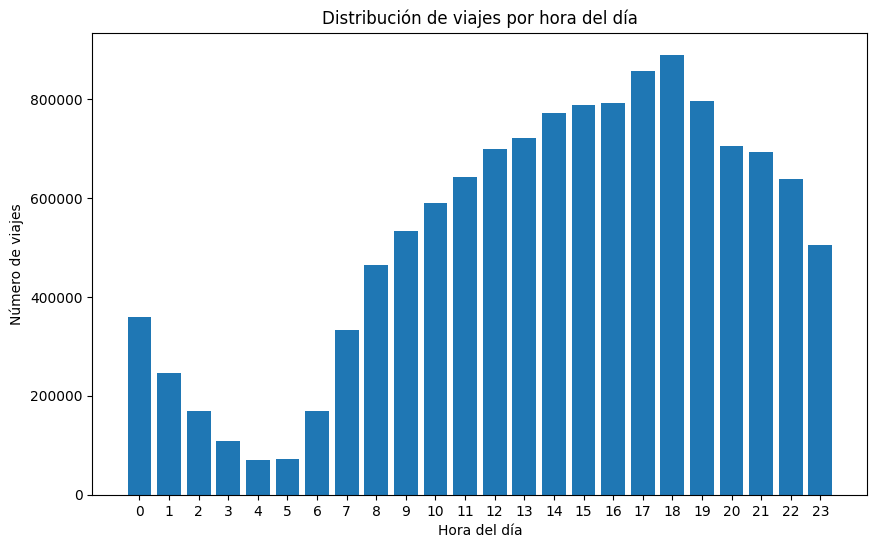

In [6]:
# Seleccionar solo las columnas necesarias para el análisis
df_hourly_trips = df_analytics.select("hour")

# Contar el número de viajes por cada hora del día
df_hourly_distribution = df_hourly_trips.groupBy("hour").count()

# Convertir el DataFrame de Spark a Pandas usando Apache Arrow
df_hourly_distribution_pandas = df_hourly_distribution.toPandas()

# Realizar el análisis: Distribución de viajes por hora del día
df_hourly_distribution_pandas = df_hourly_distribution_pandas.sort_values(by="hour")

# Generar el gráfico
plt.figure(figsize=(10, 6))
plt.bar(df_hourly_distribution_pandas["hour"], df_hourly_distribution_pandas["count"])
plt.title('Distribución de viajes por hora del día')
plt.xlabel('Hora del día')
plt.ylabel('Número de viajes')
plt.xticks(range(24))  # Asegurar que todas las horas del día se muestren en el eje x
plt.show()

# Duración promedio de viajes según el día de la semana

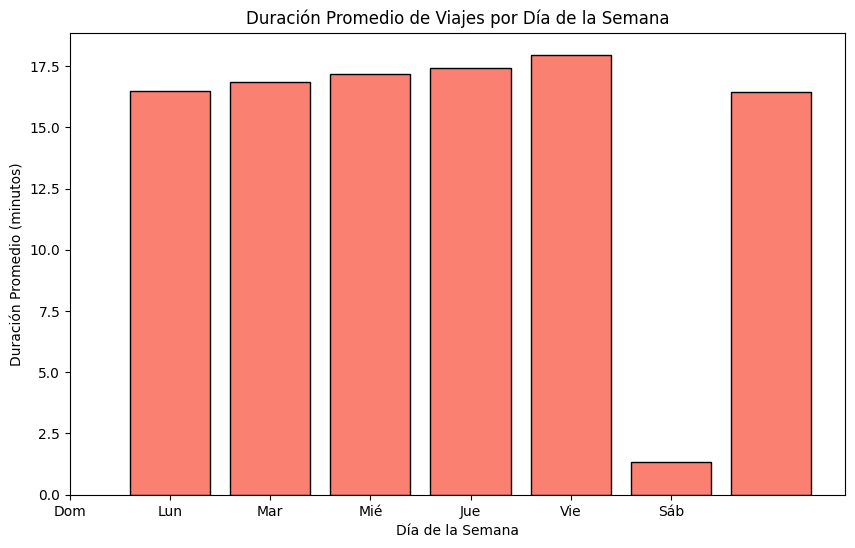

In [5]:
# Seleccionar solo las columnas necesarias para el análisis
df_trip_duration_by_day = df_analytics.select("day_of_week", "trip_duration")

# Calcular la duración promedio de viajes por día de la semana
df_avg_trip_duration_by_day = df_trip_duration_by_day.groupBy("day_of_week").avg("trip_duration")

# Convertir el DataFrame de Spark a Pandas usando Apache Arrow
df_avg_trip_duration_by_day_pandas = df_avg_trip_duration_by_day.toPandas()

# Realizar el análisis: Duración promedio de viajes según el día de la semana
df_avg_trip_duration_by_day_pandas = df_avg_trip_duration_by_day_pandas.sort_values(by="day_of_week")

# Generar el gráfico
plt.figure(figsize=(10, 6))
plt.bar(df_avg_trip_duration_by_day_pandas["day_of_week"], df_avg_trip_duration_by_day_pandas["avg(trip_duration)"], color='salmon', edgecolor='black')
plt.title('Duración Promedio de Viajes por Día de la Semana')
plt.xlabel('Día de la Semana')
plt.ylabel('Duración Promedio (minutos)')
plt.xticks(ticks=range(7), labels=['Dom', 'Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb'])
plt.show()

# Distribución de la cantidad de pasajeros 

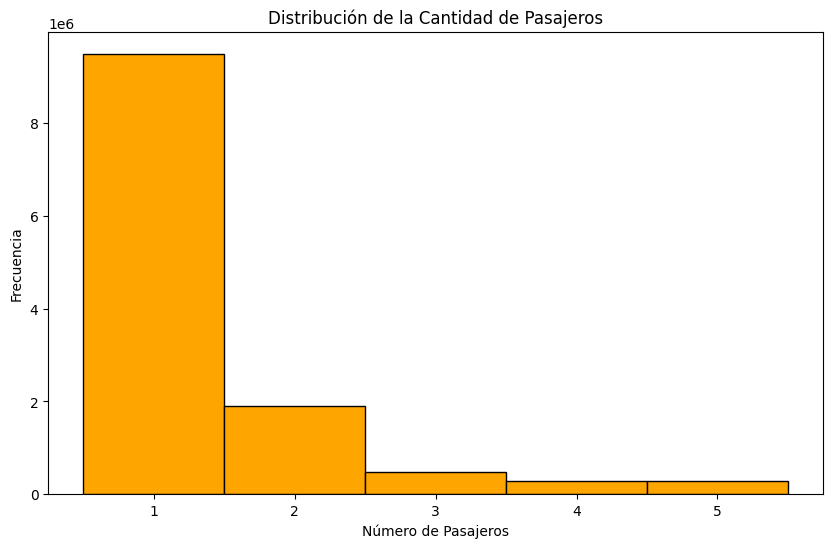

In [9]:
# Seleccionar solo la columna necesaria para el análisis
df_passenger_count = df_analytics.select("passenger_count")

# Convertir el DataFrame de Spark a Pandas usando Apache Arrow
df_passenger_count_pandas = df_passenger_count.toPandas()

# Realizar el análisis: Cantidad de pasajeros en los viajes
plt.figure(figsize=(10, 6))
df_passenger_count_pandas['passenger_count'].plot(kind='hist', bins=range(1, 7), color='orange', edgecolor='black', align='left')
plt.title('Distribución de la Cantidad de Pasajeros')
plt.xlabel('Número de Pasajeros')
plt.ylabel('Frecuencia')
plt.show()

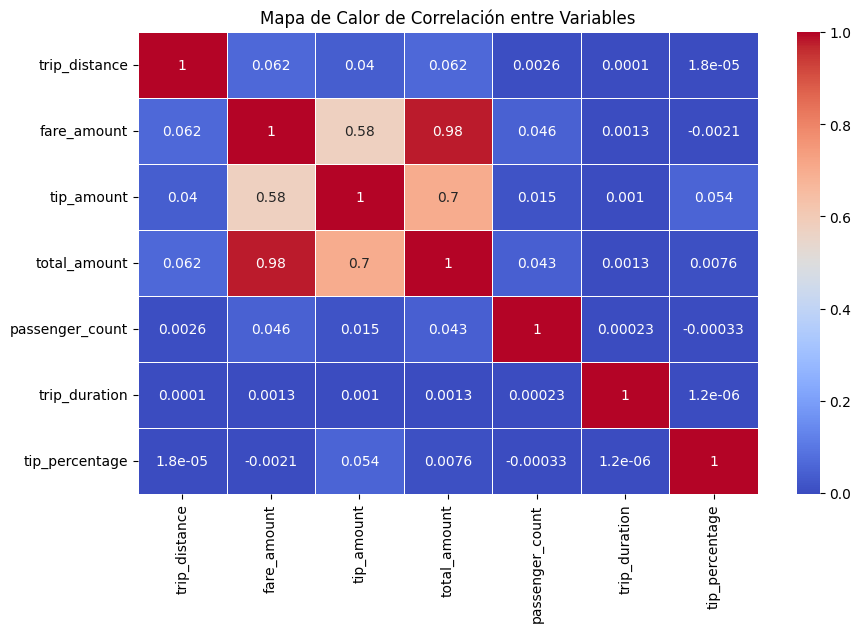

In [2]:
# Correlación entre variables
df_corr = df_analytics.select("trip_distance", "fare_amount", "tip_amount", "total_amount", "passenger_count", "trip_duration", "tip_percentage")
df_corr_pandas = df_corr.toPandas()

plt.figure(figsize=(10, 6))
correlation_matrix = df_corr_pandas.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Mapa de Calor de Correlación entre Variables')
plt.show()

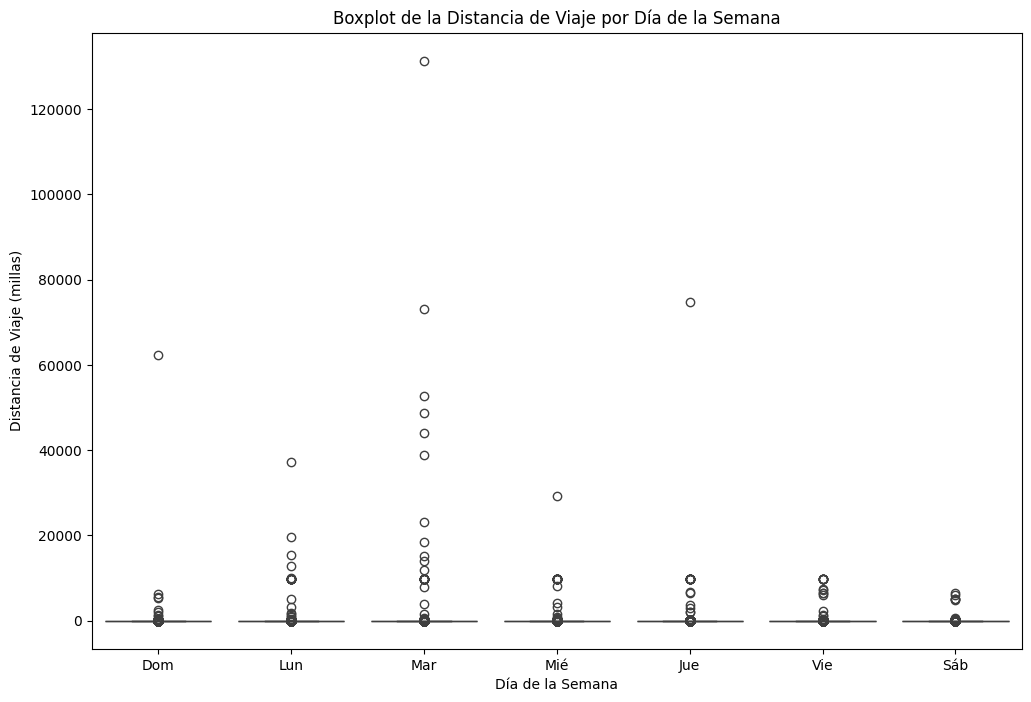

In [8]:
# Seleccionar solo las columnas necesarias para el análisis
df_trip_distance_by_day = df_analytics.select("day_of_week", "trip_distance")

# Convertir el DataFrame de Spark a Pandas usando Apache Arrow
df_trip_distance_by_day_pandas = df_trip_distance_by_day.toPandas()

# Realizar el análisis: Boxplot de la distancia de viaje por día de la semana
plt.figure(figsize=(12, 8))
sns.boxplot(x="day_of_week", y="trip_distance", data=df_trip_distance_by_day_pandas)
plt.title('Boxplot de la Distancia de Viaje por Día de la Semana')
plt.xlabel('Día de la Semana')
plt.ylabel('Distancia de Viaje (millas)')
plt.xticks(ticks=range(7), labels=['Dom', 'Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb'])
plt.show()

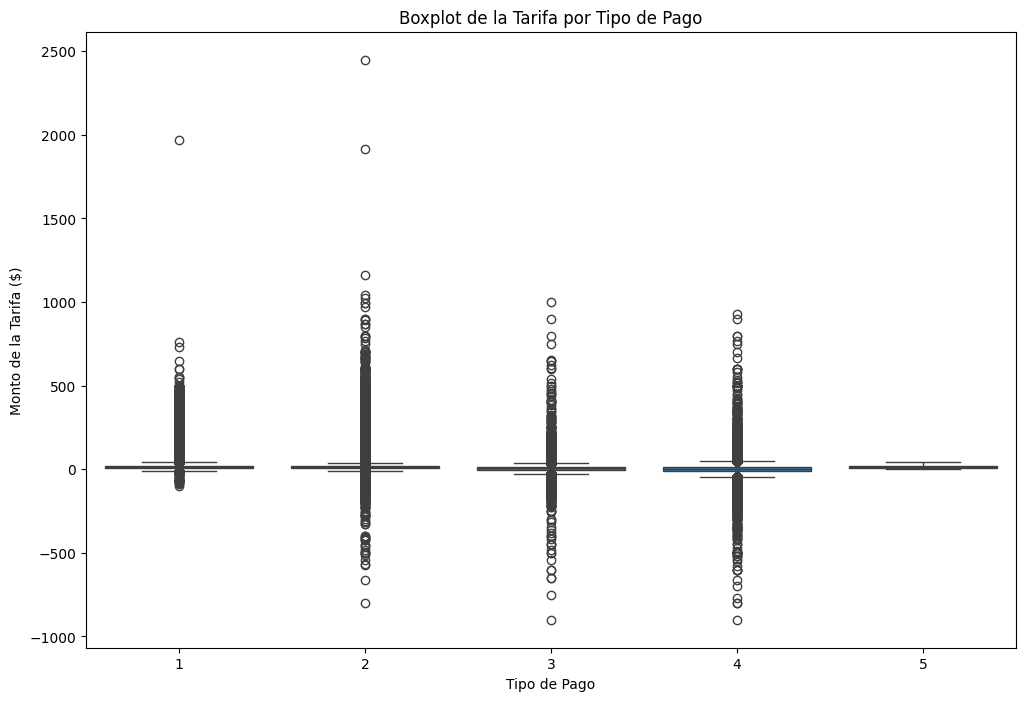

In [4]:
# Seleccionar solo las columnas necesarias para el análisis
df_fare_by_payment_type = df_analytics.select("payment_type", "fare_amount")

# Convertir el DataFrame de Spark a Pandas usando Apache Arrow
df_fare_by_payment_type_pandas = df_fare_by_payment_type.toPandas()

# Realizar el análisis: Boxplot de la tarifa por tipo de pago
plt.figure(figsize=(12, 8))
sns.boxplot(x="payment_type", y="fare_amount", data=df_fare_by_payment_type_pandas)
plt.title('Boxplot de la Tarifa por Tipo de Pago')
plt.xlabel('Tipo de Pago')
plt.ylabel('Monto de la Tarifa ($)')
plt.show()

/tmp/ipykernel_11619/41787671.py:7: FutureWarning:                              

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="taxi_type", y="avg(trip_duration)", data=df_avg_duration_by_taxi_type_pandas, palette="viridis")


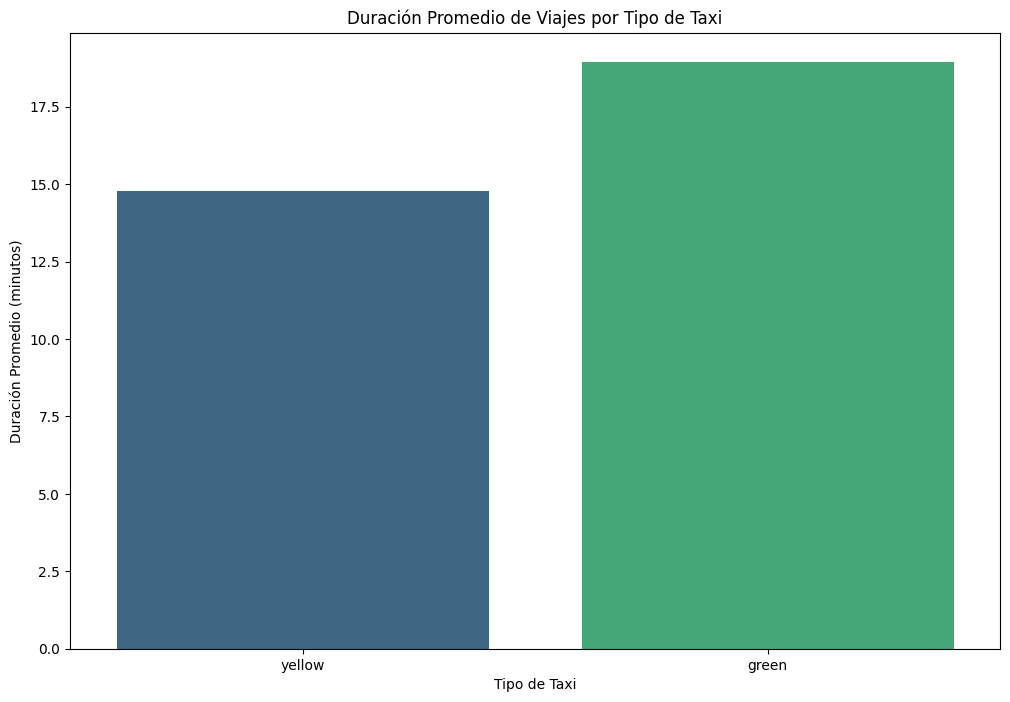

In [8]:
# 2. Duración promedio de los viajes por tipo de taxi
df_duration_by_taxi_type = df_analytics.select("taxi_type", "trip_duration")
df_avg_duration_by_taxi_type = df_duration_by_taxi_type.groupBy("taxi_type").avg("trip_duration")
df_avg_duration_by_taxi_type_pandas = df_avg_duration_by_taxi_type.toPandas()

plt.figure(figsize=(12, 8))
sns.barplot(x="taxi_type", y="avg(trip_duration)", data=df_avg_duration_by_taxi_type_pandas, palette="viridis")
plt.title('Duración Promedio de Viajes por Tipo de Taxi')
plt.xlabel('Tipo de Taxi')
plt.ylabel('Duración Promedio (minutos)')
plt.show()

# ¿Cuál es la diferencia en ingresos entre los taxis amarillos y verdes?

In [6]:
from pyspark.sql.functions import col, avg, stddev

# Filtrar los datos por tipo de taxi
df_yellow_taxis = df_analytics.filter(col("taxi_type") == "yellow")
df_green_taxis = df_analytics.filter(col("taxi_type") == "green")

# Calcular la suma de total_amount para cada tipo de taxi
total_amount_yellow = df_yellow_taxis.agg({"total_amount": "sum"}).collect()[0][0]
total_amount_green = df_green_taxis.agg({"total_amount": "sum"}).collect()[0][0]

print(f"Ingresos totales de taxis amarillos: ${total_amount_yellow}")
print(f"Ingresos totales de taxis verdes: ${total_amount_green}")

# Calcular estadísticas descriptivas para cada tipo de taxi
stats_yellow = df_yellow_taxis.agg(
    avg("total_amount").alias("mean_total_amount"),
    stddev("total_amount").alias("stddev_total_amount")
).collect()[0]

stats_green = df_green_taxis.agg(
    avg("total_amount").alias("mean_total_amount"),
    stddev("total_amount").alias("stddev_total_amount")
).collect()[0]

print(f"Estadísticas de taxis amarillos: Media = {stats_yellow['mean_total_amount']}, Desviación estándar = {stats_yellow['stddev_total_amount']}")
print(f"Estadísticas de taxis verdes: Media = {stats_green['mean_total_amount']}, Desviación estándar = {stats_green['stddev_total_amount']}")

# Interpretar los resultados
if stats_yellow['mean_total_amount'] > stats_green['mean_total_amount']:
    print("Los taxis amarillos tienen un ingreso promedio mayor que los taxis verdes.")
else:
    print("Los taxis verdes tienen un ingreso promedio mayor que los taxis amarillos.")

Ingresos totales de taxis amarillos: $349734370.03942704
Ingresos totales de taxis verdes: $5565494.430000111


Estadísticas de taxis amarillos: Media = 28.24547501316044, Desviación estándar = 23.775214623906617
Estadísticas de taxis verdes: Media = 22.911943740017254, Desviación estándar = 18.31013760837136
Los taxis amarillos tienen un ingreso promedio mayor que los taxis verdes.


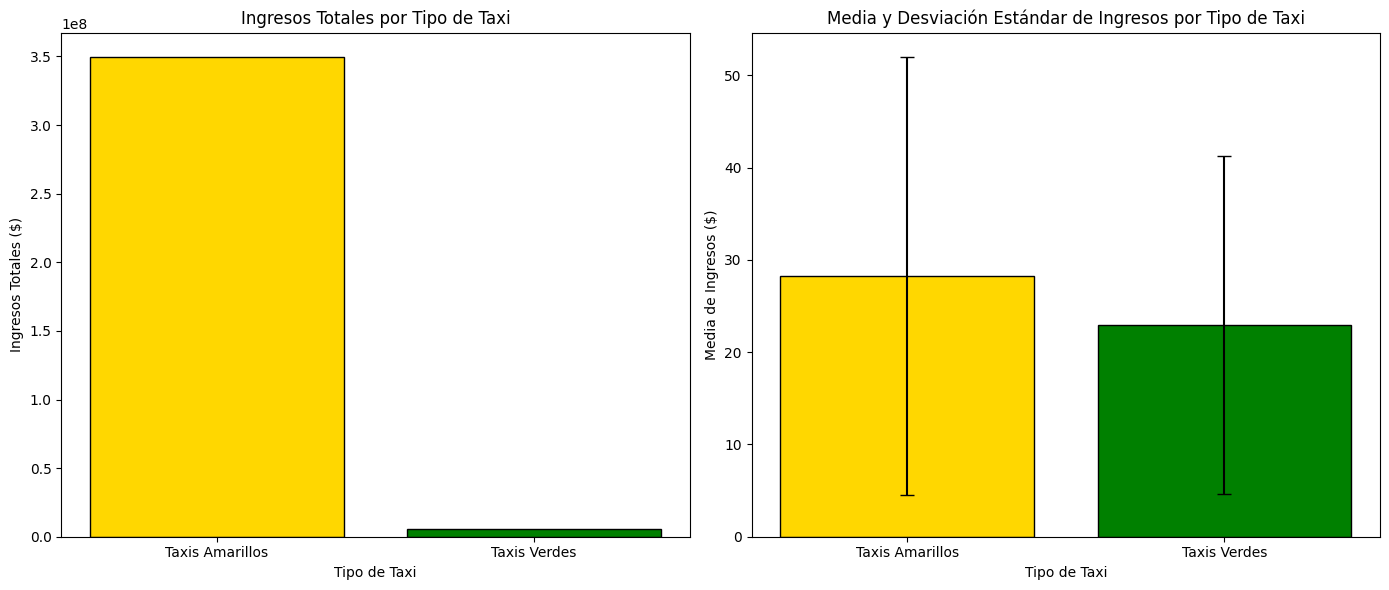

In [7]:
# Filtrar los datos por tipo de taxi
df_yellow_taxis = df_analytics.filter(col("taxi_type") == "yellow")
df_green_taxis = df_analytics.filter(col("taxi_type") == "green")

# Calcular la suma de total_amount para cada tipo de taxi
total_amount_yellow = df_yellow_taxis.agg({"total_amount": "sum"}).collect()[0][0]
total_amount_green = df_green_taxis.agg({"total_amount": "sum"}).collect()[0][0]

# Calcular estadísticas descriptivas para cada tipo de taxi
stats_yellow = df_yellow_taxis.agg(
    avg("total_amount").alias("mean_total_amount"),
    stddev("total_amount").alias("stddev_total_amount")
).collect()[0]

stats_green = df_green_taxis.agg(
    avg("total_amount").alias("mean_total_amount"),
    stddev("total_amount").alias("stddev_total_amount")
).collect()[0]

# Datos para el gráfico
labels = ['Taxis Amarillos', 'Taxis Verdes']
total_amounts = [total_amount_yellow, total_amount_green]
means = [stats_yellow['mean_total_amount'], stats_green['mean_total_amount']]
stddevs = [stats_yellow['stddev_total_amount'], stats_green['stddev_total_amount']]

# Crear el gráfico
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Gráfico de barras para los ingresos totales
ax[0].bar(labels, total_amounts, color=['gold', 'green'], edgecolor='black')
ax[0].set_title('Ingresos Totales por Tipo de Taxi')
ax[0].set_ylabel('Ingresos Totales ($)')
ax[0].set_xlabel('Tipo de Taxi')

# Gráfico de barras con error bars para la media y desviación estándar
ax[1].bar(labels, means, yerr=stddevs, capsize=5, color=['gold', 'green'], edgecolor='black')
ax[1].set_title('Media y Desviación Estándar de Ingresos por Tipo de Taxi')
ax[1].set_ylabel('Media de Ingresos ($)')
ax[1].set_xlabel('Tipo de Taxi')

# Ajustar el diseño
plt.tight_layout()
plt.show()

# ¿Qué zonas generan más ingresos?

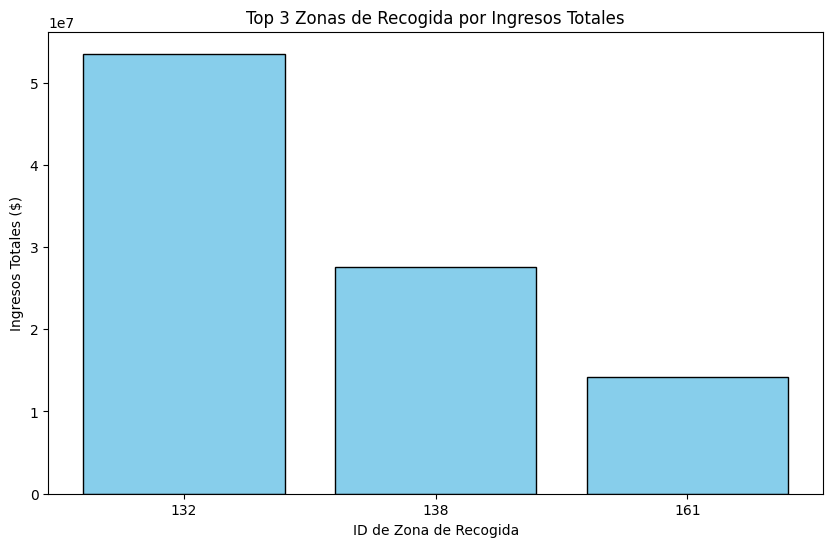

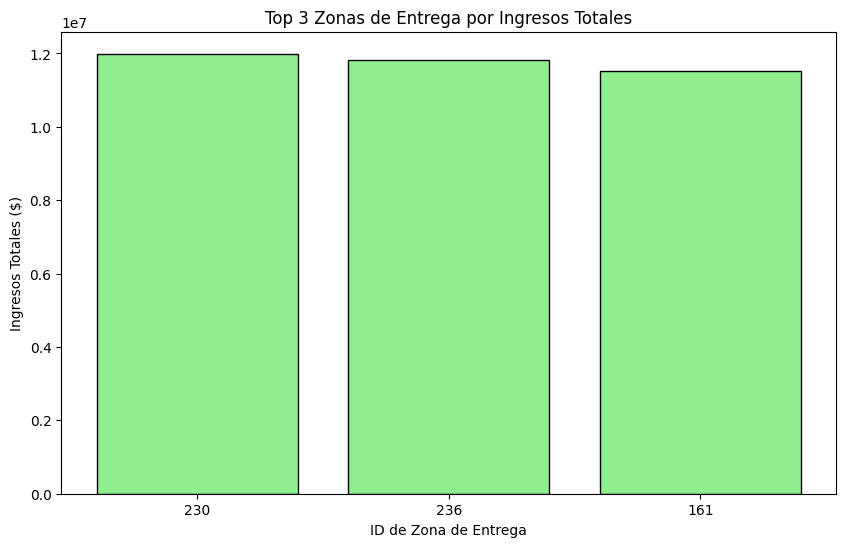

In [11]:
from pyspark.sql.functions import col, sum as spark_sum

# Agrupar los datos por PULocationID y calcular la suma de total_amount
df_income_by_pickup = df_analytics.groupBy("PULocationID").agg(spark_sum("total_amount").alias("total_income"))
df_income_by_pickup = df_income_by_pickup.orderBy(col("total_income").desc()).limit(3)

# Agrupar los datos por DOLocationID y calcular la suma de total_amount
df_income_by_dropoff = df_analytics.groupBy("DOLocationID").agg(spark_sum("total_amount").alias("total_income"))
df_income_by_dropoff = df_income_by_dropoff.orderBy(col("total_income").desc()).limit(3)

# Convertir los DataFrames de Spark a Pandas para la visualización
df_income_by_pickup_pandas = df_income_by_pickup.toPandas()
df_income_by_dropoff_pandas = df_income_by_dropoff.toPandas()

# Visualizar los ingresos por zona de recogida (Top 3)
plt.figure(figsize=(10, 6))
plt.bar(df_income_by_pickup_pandas["PULocationID"].astype(str), df_income_by_pickup_pandas["total_income"], color='skyblue', edgecolor='black')
plt.title('Top 3 Zonas de Recogida por Ingresos Totales')
plt.xlabel('ID de Zona de Recogida')
plt.ylabel('Ingresos Totales ($)')
plt.xticks(rotation=0)
plt.show()

# Visualizar los ingresos por zona de entrega (Top 3)
plt.figure(figsize=(10, 6))
plt.bar(df_income_by_dropoff_pandas["DOLocationID"].astype(str), df_income_by_dropoff_pandas["total_income"], color='lightgreen', edgecolor='black')
plt.title('Top 3 Zonas de Entrega por Ingresos Totales')
plt.xlabel('ID de Zona de Entrega')
plt.ylabel('Ingresos Totales ($)')
plt.xticks(rotation=0)
plt.show()

# ¿Cómo varían las propinas según el método de pago?

/tmp/ipykernel_12385/1124412404.py:14: FutureWarning:                           

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="payment_type", y="mean_tip", data=df_tip_stats_pandas, palette="viridis", edgecolor='black')


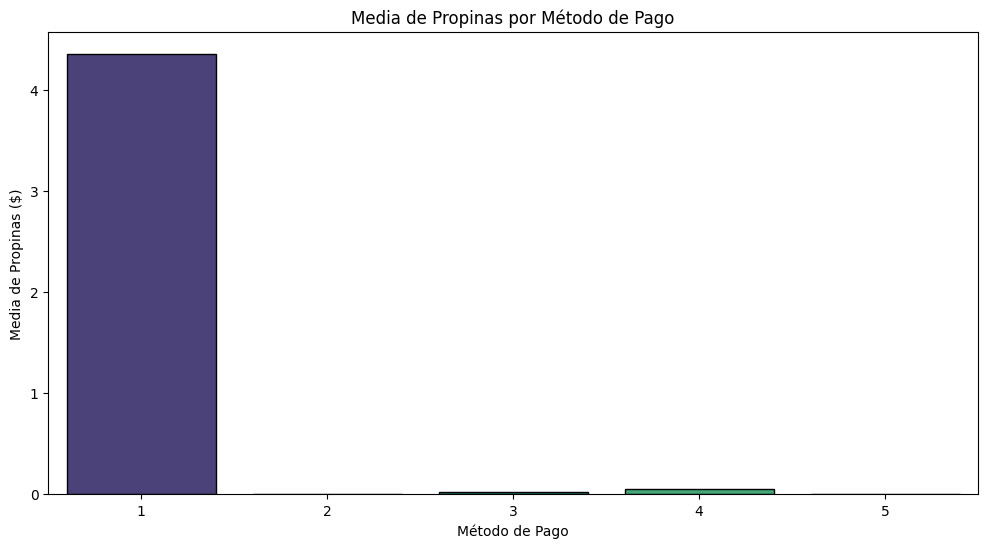

/tmp/ipykernel_12385/1124412404.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="payment_type", y="median_tip", data=df_tip_stats_pandas, palette="viridis", edgecolor='black')


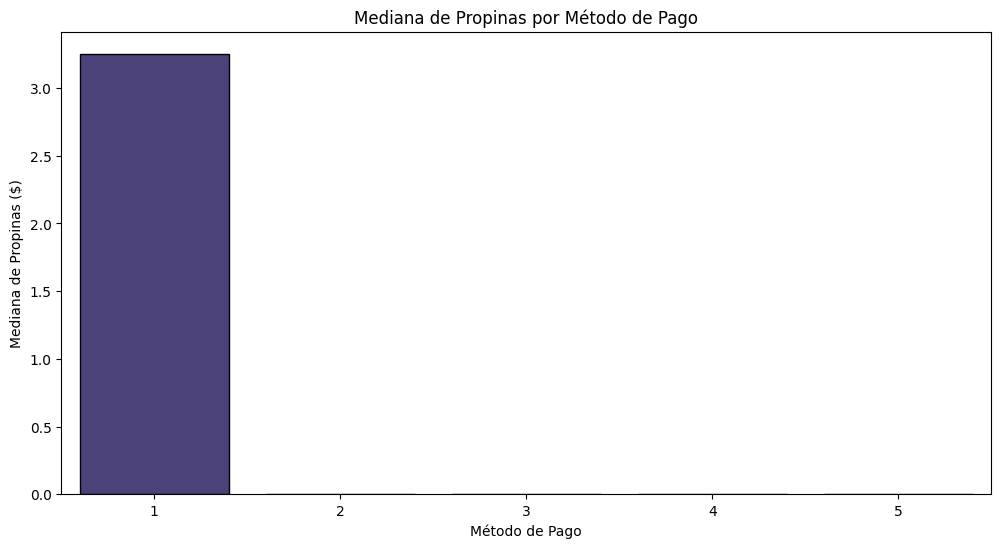

/tmp/ipykernel_12385/1124412404.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="payment_type", y="stddev_tip", data=df_tip_stats_pandas, palette="viridis", edgecolor='black')


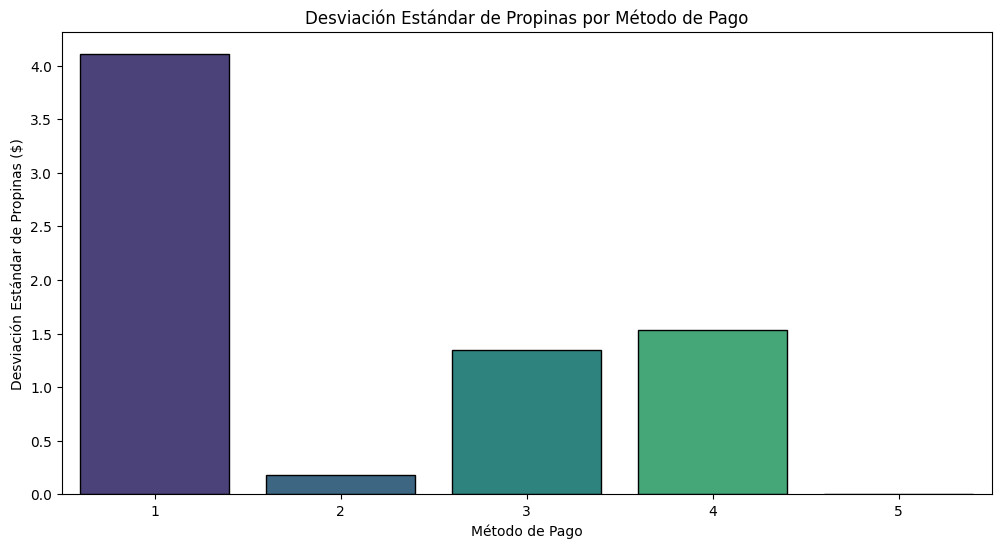

/tmp/ipykernel_12385/1124412404.py:38: FutureWarning:                           

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="payment_type", y="tip_amount", data=df_tip_by_payment_type, palette="viridis")


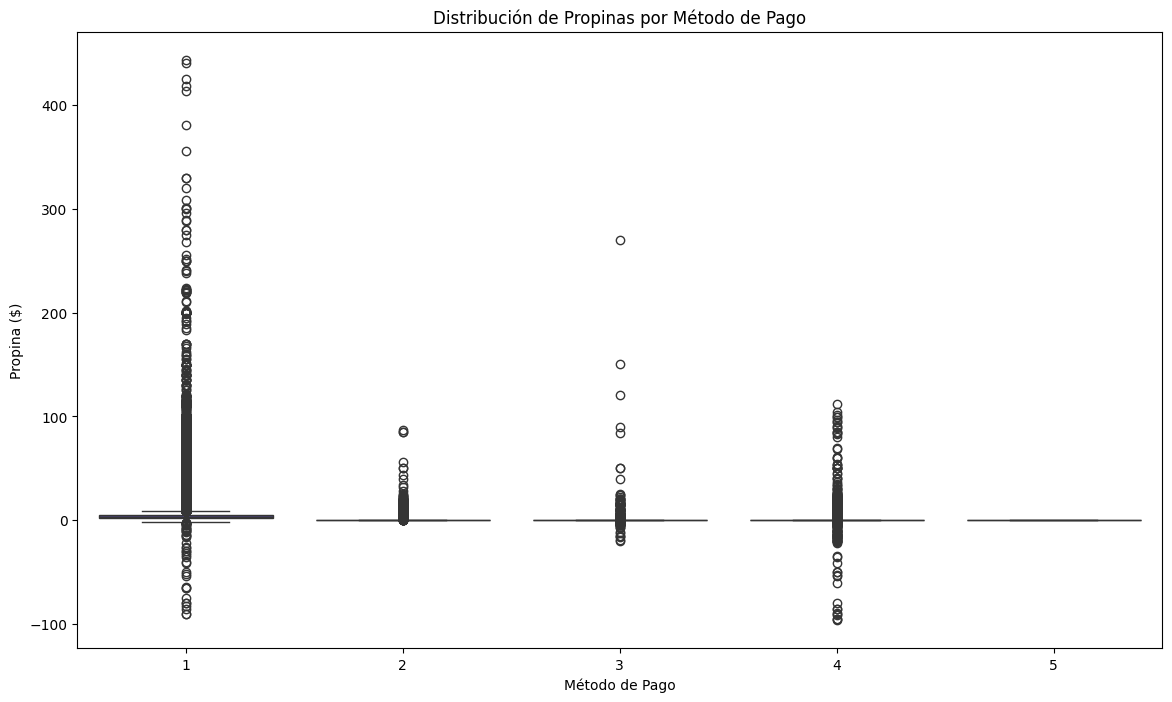

In [12]:
from pyspark.sql.functions import col, avg, stddev, expr
# Agrupar los datos por payment_type y calcular estadísticas descriptivas del tip_amount
df_tip_stats = df_analytics.groupBy("payment_type").agg(
    avg("tip_amount").alias("mean_tip"),
    expr("percentile_approx(tip_amount, 0.5)").alias("median_tip"),
    stddev("tip_amount").alias("stddev_tip")
)

# Convertir el DataFrame de Spark a Pandas para la visualización
df_tip_stats_pandas = df_tip_stats.toPandas()

# Visualizar las estadísticas descriptivas de las propinas por método de pago
plt.figure(figsize=(12, 6))
sns.barplot(x="payment_type", y="mean_tip", data=df_tip_stats_pandas, palette="viridis", edgecolor='black')
plt.title('Media de Propinas por Método de Pago')
plt.xlabel('Método de Pago')
plt.ylabel('Media de Propinas ($)')
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x="payment_type", y="median_tip", data=df_tip_stats_pandas, palette="viridis", edgecolor='black')
plt.title('Mediana de Propinas por Método de Pago')
plt.xlabel('Método de Pago')
plt.ylabel('Mediana de Propinas ($)')
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x="payment_type", y="stddev_tip", data=df_tip_stats_pandas, palette="viridis", edgecolor='black')
plt.title('Desviación Estándar de Propinas por Método de Pago')
plt.xlabel('Método de Pago')
plt.ylabel('Desviación Estándar de Propinas ($)')
plt.show()

# Visualizar la distribución de las propinas por método de pago usando boxplots
df_tip_by_payment_type = df_analytics.select("payment_type", "tip_amount").toPandas()

plt.figure(figsize=(14, 8))
sns.boxplot(x="payment_type", y="tip_amount", data=df_tip_by_payment_type, palette="viridis")
plt.title('Distribución de Propinas por Método de Pago')
plt.xlabel('Método de Pago')
plt.ylabel('Propina ($)')
plt.show()

# ¿Cuál es la duración promedio de los viajes por zona?

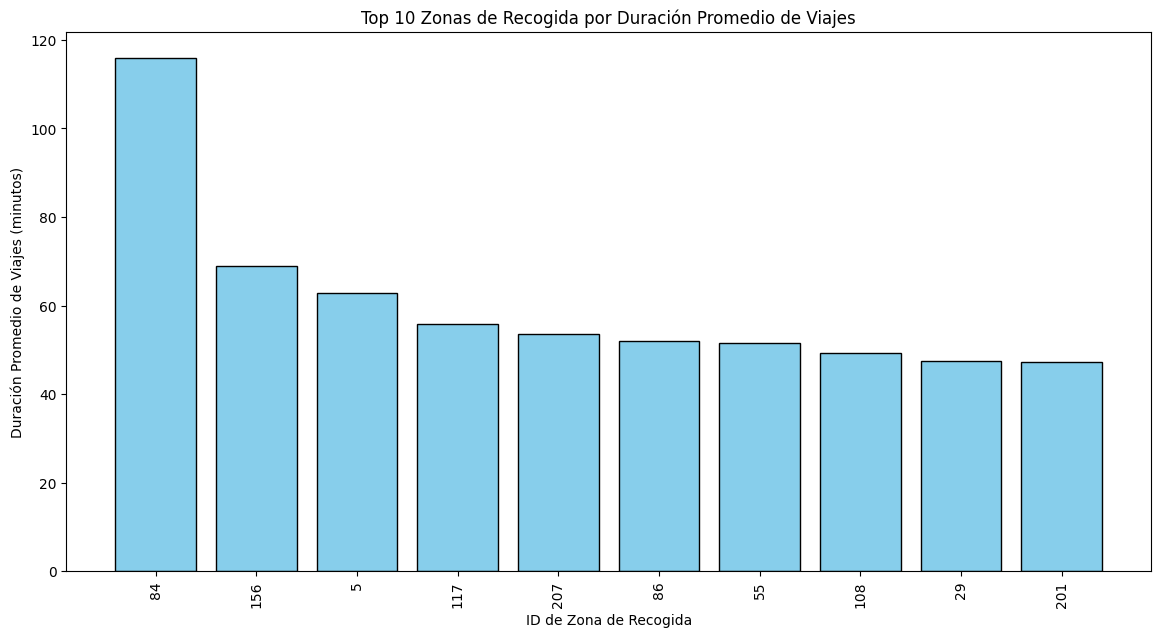

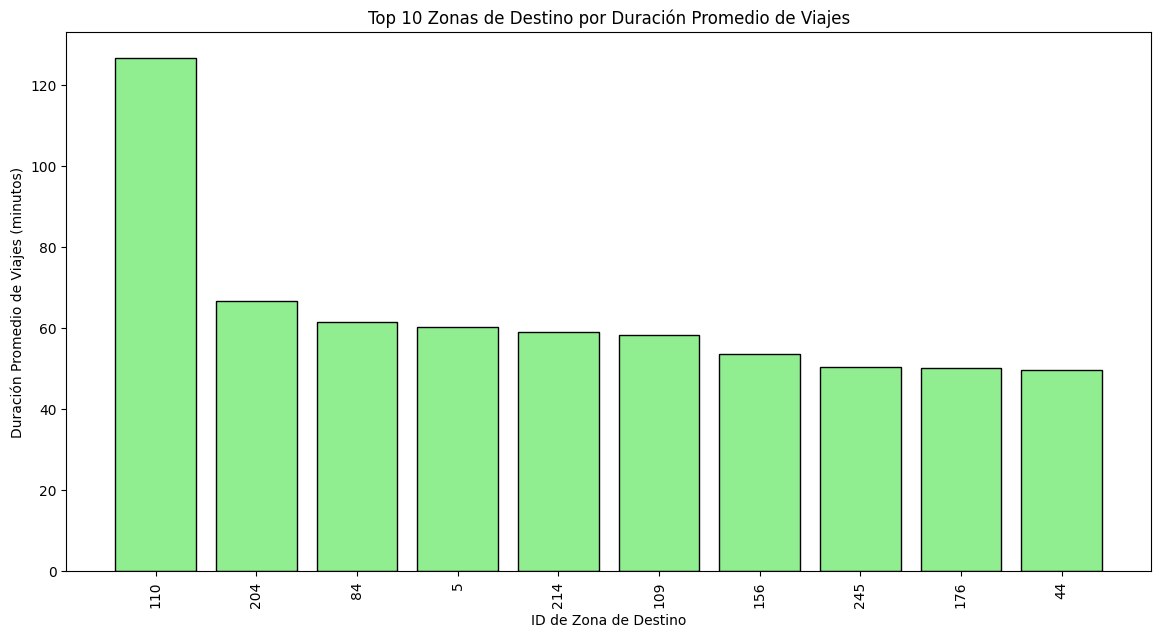

In [3]:
from pyspark.sql.functions import col, avg

# Agrupar los datos por PULocationID y calcular la duración promedio de los viajes
df_avg_duration_by_pickup = df_analytics.groupBy("PULocationID").agg(avg("trip_duration").alias("avg_trip_duration"))
df_avg_duration_by_pickup = df_avg_duration_by_pickup.orderBy(col("avg_trip_duration").desc()).limit(10)

# Agrupar los datos por DOLocationID y calcular la duración promedio de los viajes
df_avg_duration_by_dropoff = df_analytics.groupBy("DOLocationID").agg(avg("trip_duration").alias("avg_trip_duration"))
df_avg_duration_by_dropoff = df_avg_duration_by_dropoff.orderBy(col("avg_trip_duration").desc()).limit(10)

# Convertir los DataFrames de Spark a Pandas para la visualización
df_avg_duration_by_pickup_pandas = df_avg_duration_by_pickup.toPandas()
df_avg_duration_by_dropoff_pandas = df_avg_duration_by_dropoff.toPandas()

# Visualizar la duración promedio de los viajes por zona de recogida (Top 10)
plt.figure(figsize=(14, 7))
plt.bar(df_avg_duration_by_pickup_pandas["PULocationID"].astype(str), df_avg_duration_by_pickup_pandas["avg_trip_duration"], color='skyblue', edgecolor='black')
plt.title('Top 10 Zonas de Recogida por Duración Promedio de Viajes')
plt.xlabel('ID de Zona de Recogida')
plt.ylabel('Duración Promedio de Viajes (minutos)')
plt.xticks(rotation=90)
plt.show()

# Visualizar la duración promedio de los viajes por zona de destino (Top 10)
plt.figure(figsize=(14, 7))
plt.bar(df_avg_duration_by_dropoff_pandas["DOLocationID"].astype(str), df_avg_duration_by_dropoff_pandas["avg_trip_duration"], color='lightgreen', edgecolor='black')
plt.title('Top 10 Zonas de Destino por Duración Promedio de Viajes')
plt.xlabel('ID de Zona de Destino')
plt.ylabel('Duración Promedio de Viajes (minutos)')
plt.xticks(rotation=90)
plt.show()